In [9]:
import numpy as np
from scipy.optimize import minimize
from desdeo_problem import variable_builder, ScalarObjective, MOProblem
from desdeo_problem.testproblems.TestProblems import test_problem_builder
import plotly.graph_objects as go
from desdeo_mcdm.utilities.solvers import solve_pareto_front_representation
from desdeo_mcdm.interactive.ReferencePointMethod import ReferencePointMethod
import matplotlib.pyplot as plt
from gekko import GEKKO


In [10]:
# Define objective functions
def f1(x):
    f= x[0]
    return f

def f2(x):
    g = 1 + 9.0 / (5 - 1) * np.sum(x[1:])
    f2x = g * (1 - np.power((x[0] / g), 0.5))
    return f2x

def compute_multipliers(objectives, num_variables, lower_bounds, upper_bounds, w, z_dot):
    # Initial guess for alpha and variables
    m = GEKKO(remote=False)

    alpha = m.Var(value=0)  # Variable alpha
    x=m.Array(m.Var,num_variables)

    for i in range(num_variables):
        x[i].lower = 0
        x[i].upper = 1

    m.Obj(alpha)  # Objective function to minimize
    num_objectives = len(objectives)

    # Define Constraints
    for i in range(num_objectives):
        m.Equation(w[i] * (objectives[i](x) - z_dot[i]) <= alpha)
    
    m.options.DIAGLEVEL=2

    # Minimize alpha subject to the constraints
    m.solve(disp=False)
    print(f"Optimal value of alpha: {alpha.value[0]}")
    print('Lagrange multipliers')
    lam = np.loadtxt(m.path + '/apm_lam.txt')
    lam*=-1
    print(lam)
    print("Value of x")
    flattened_x = [item for sublist in x for item in sublist]
    print(flattened_x)
    # Calculate Lagrange multipliers
    #lagrange_multipliers = np.array([item for sublist in result.v for item in sublist])
    #lagrange_multipliers[0:num_objectives] *= -1
    #lagrange_multipliers = result.grad[:-1]
    return np.array(flattened_x), lam


In [11]:
def compute_approximate_pareto_optimal_objective_vector(dot_z, lambdas, d, weights):
    """
    Compute the approximate Pareto optimal objective vector.

    Args:
    dot_z (numpy.ndarray): Current objective vector.
    d (numpy.ndarray): Direction vector.
    n (numpy.ndarray): Normal vector.
    w_inv (numpy.ndarray): Inverse of the weight vector.

    Returns:
    numpy.ndarray: Approximate Pareto optimal objective vector.
    """
    k = len(dot_z)  # Number of objectives
    w_inv = 1 / np.array(weights)
    n = -np.array([lambdas[i] * weights[i] for i in range(k)])
    local_trade_off = -(lambdas[1] * weights[1])/(lambdas[0] * weights[0])
    print("Local trade off",local_trade_off)
    d = np.array(d)
    n = np.array(n)
    w_inv = np.array(w_inv)
    t = -np.dot(n.T, d) / np.dot(n.T, w_inv)
    approximate_z = dot_z + d + t * w_inv
    print("Approximated z",approximate_z)
    return approximate_z

Optimal value of alpha: -0.059016782795
Lagrange multipliers
[0.4480251 0.5519749]
Value of x
[0.38196549858, 6.9449012519e-10, 6.9449012519e-10, 6.9449012519e-10, 6.9449012519e-10]
0.381966430328001
Local trade off -1.2320178016096113
Approximated z [0.10597805 0.60597898]
Local trade off -1.2320178016096113
Approximated z [0.54755797 0.2475589 ]


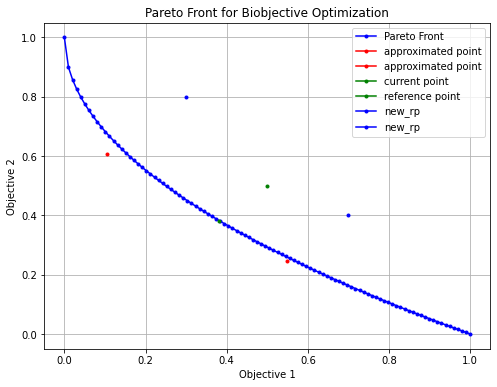

In [12]:
# Main function to compute and plot Pareto front
def plot(w, z_i, z_dot, d, d2, approximate_z, approximate_z2):
    # Decision variable range
    # Generate x values
    sample_size = 100
    objDim=2

    P       = np.zeros((sample_size, objDim))
    f11      = np.linspace(0, 1, sample_size)
    P[:, 0] = f11
    P[: ,1] = np.ones(sample_size) - np.sqrt(P[:, 0])
    # Plot Pareto front
    plt.figure(figsize=(8, 6))
    plt.plot(P[:, 0], P[:, 1], label='Pareto Front', color='blue', marker='.')
    plt.plot(approximate_z[0], approximate_z[1], label='approximated point', color='red', marker='.')
    plt.plot(approximate_z2[0], approximate_z2[1], label='approximated point', color='red', marker='.')
    plt.plot(z_i[0], z_i[1], label='current point', color='green', marker='.')
    plt.plot(z_dot[0], z_dot[1], label='reference point', color='green', marker='.')
    plt.plot(z_dot[0] + d[0], z_dot[1] + d[1], label='new_rp', color='blue', marker='.')
    plt.plot(z_dot[0] + d2[0], z_dot[1] + d2[1], label='new_rp', color='blue', marker='.')

    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title('Pareto Front for Biobjective Optimization')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    num_variables = 5
    lower_bounds = [0,0,0,0,0]
    upper_bounds = [1,1,1,1,1]
    w = [0.5,0.5]   
    z_dot = [0.5,0.5]
    d = [-0.2, 0.3]
    d2 = [0.2,-0.1]
    
    objectives = [f1,f2]
    x, lagrange_multipliers = compute_multipliers(objectives, num_variables, lower_bounds, upper_bounds, w, z_dot)
    print(f2(x))
    fx = [f1(x), f2(x)]

    approximate_z = compute_approximate_pareto_optimal_objective_vector(fx,lagrange_multipliers, d, w)
    approximate_z2 = compute_approximate_pareto_optimal_objective_vector(fx,lagrange_multipliers, d2, w)
    plot(w, fx, z_dot, d, d2, approximate_z, approximate_z2)

    objective_vectors = [fx, approximate_z, approximate_z2]